# Pipeline A- Normalize Skew

In [1]:
# for preprocessing/eda models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import kurtosis, skew
import math
from scipy.stats import norm

# feature selection
from sklearn.feature_selection import RFE

# balancing
from imblearn.over_sampling import SMOTE

# accuracy metrics and data split models
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 500) # display max 500 rows
pd.set_option('display.max_rows', 140)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

In [2]:
# read in data to skip innitial steps from pipeline B
data = pd.read_csv('online_shoppers_intention-2.csv')
data1 = data.copy() # copy of original df
data1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
data1.Weekend.value_counts()

False    9462
True     2868
Name: Weekend, dtype: int64

## Imputation 
- assumption that exit rates cannot be zero

In [4]:
# impute our assumption (beccomes a new feature)
data1['ExitRatesImpute'] = data1['ExitRates'].replace(0,np.NaN)
data1['ExitRatesImpute'] = data1['ExitRatesImpute'].fillna(data1['ExitRatesImpute'].median())

## Feature Engineering (Ratios, aggregation)
- calculate ratios for count of page visits 
- combine bounce and exit rates (average and weighted average - new features)
    - they have a strong linear relationship
- divide features that have strong non-linear relationship 
    - solve zero-division by replacing it with 0 (e.g. 1/0 = n/a)

In [5]:
# ratios for counts
data1['totalFracAdmin'] = data1['Administrative']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracInfo'] = data1['Informational']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracProd'] = data1['ProductRelated']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])

# average combining
data1['BounceExitAvg'] = (data1['BounceRates'] + data1['ExitRates'])/2

# weighted-average feature joining
data1['BounceExitW1'] = data1['BounceRates'] * 0.6 + data1['ExitRates'] * 0.4
data1['BounceExitW2'] = data1['BounceRates'] * 0.7 + data1['ExitRates'] * 0.3
data1['BounceExitW3'] = data1['BounceRates'] * 0.4 + data1['ExitRates'] * 0.6
data1['BounceExitW4'] = data1['BounceRates'] * 0.3 + data1['ExitRates'] * 0.7

# bounce and exit rates vs page values ratio 
data1['BouncePageRatio'] = data1['BounceRates']/data1['PageValues']
data1['ExitPageRatio'] = data1['ExitRates']/data1['PageValues']

# durations vs page values, bounce and exit rates
data1['InfoPageRatio'] = data1['Informational_Duration']/data1['PageValues']
data1['ProdRelPageRatio'] = data1['ProductRelated_Duration']/data1['PageValues']
data1['InfoBounceRatio'] = data1['Informational_Duration']/data1['BounceRates']
data1['AdminBounceRatio'] = data1['Administrative_Duration']/data1['BounceRates']
data1['ProdRelBounceRatio'] = data1['ProductRelated_Duration']/data1['BounceRates']
data1['InfoExitRatio'] = data1['Informational_Duration']/data1['ExitRates']
data1['AdminBounceRatio'] = data1['Administrative_Duration']/data1['ExitRates']
data1['ProdRelExitRatio'] = data1['ProductRelated_Duration']/data1['ExitRates']

# page values, bounce and exit rates vs durations
#data1['PageInfoRatio'] = data1['PageValues']/data1['Informational_Duration']
#data1['PageProdRelRatio'] = data1['PageValues']/data1['ProductRelated_Duration']
#data1['BounceInfoRatio'] = data1['BounceRates']/data1['Informational_Duration']
#data1['BounceAdminRatio'] = data1['BounceRates']/data1['Administrative_Duration']
#data1['BounceProdRelRatio'] = data1['BounceRates']/data1['ProductRelated_Duration']
#data1['ExitInfoRatio'] = data1['ExitRates']/data1['Informational_Duration']
#data1['BounceAdminRatio'] = data1['ExitRates']/data1['Administrative_Duration']
#data1['ExitProdRelRatio'] = data1['ExitRates']/data1['ProductRelated_Duration']

# as there are many zero values --> e.g. x/0 (zero-division) = N/A or inf can occur 
# if there is zero-division treat that as a zero
data1 = data1.fillna(0) # fill N/A with 0 
data1 = data1.replace(np.inf, 0) # replace inf wit 0
data1 = data1.replace(-0, 0) # for some reason we also get -0 just fix it to 0 

In [6]:
print('Original number of features: ', len(data.columns))
print('Number of features added: ', len(data1.columns) - len(data.columns))
print('Total number of features after feature engineering: ', len(data1.columns) + len(data.columns))

Original number of features:  18
Number of features added:  18
Total number of features after feature engineering:  54


## Standardization

In [7]:
# make a copy
standardize = data1.copy()  
# select continous features (exclude Special Day)
standardize = standardize.select_dtypes(include='float64').drop('SpecialDay', axis = 1)

In [8]:
# import MinMaxScaler module
from sklearn.preprocessing import MinMaxScaler

# use MinMaxScaler function 
scaler = MinMaxScaler()

# min-max standerdize all continous columns
standardize[standardize.columns] = scaler.fit_transform(standardize[standardize.columns]) # fit the scaler to the model 
standardize_done = standardize.add_suffix('_Scaled') # add suffix (new features)

# add new standerdized features to data1
data1 = pd.concat([data1, standardize_done], axis = 1 )

#use .describe() to prove standardization worked
standardize_done.describe()

,Administrative_Duration_Scaled,Informational_Duration_Scaled,ProductRelated_Duration_Scaled,BounceRates_Scaled,ExitRates_Scaled,PageValues_Scaled,ExitRatesImpute_Scaled,totalFracAdmin_Scaled,totalFracInfo_Scaled,totalFracProd_Scaled,BounceExitAvg_Scaled,BounceExitW1_Scaled,BounceExitW2_Scaled,BounceExitW3_Scaled,BounceExitW4_Scaled,BouncePageRatio_Scaled,ExitPageRatio_Scaled,InfoPageRatio_Scaled,ProdRelPageRatio_Scaled,InfoBounceRatio_Scaled,AdminBounceRatio_Scaled,ProdRelBounceRatio_Scaled,InfoExitRatio_Scaled,ProdRelExitRatio_Scaled
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.00000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,0.023779,0.013522,0.018676,0.110957,0.215364,0.016279,0.215459,0.079955,0.01446,0.905098,0.163160,0.152720,0.142279,0.173601,0.184042,0.001512,0.001537,0.001563,0.000596,0.001190,0.001255,0.001096,0.005869,0.006603
std,0.052013,0.055209,0.029913,0.242442,0.242983,0.051328,0.242704,0.126751,0.05037,0.141883,0.237375,0.237535,0.238127,0.237646,0.238347,0.015647,0.013210,0.019200,0.012077,0.016869,0.011059,0.015312,0.030030,0.019537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.002878,0.000000,0.071429,0.000000,0.070613,0.000000,0.00000,0.860465,0.039532,0.033333,0.025805,0.046154,0.052593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000338
50%,0.002207,0.000000,0.009362,0.015562,0.125782,0.000000,0.126436,0.021661,0.00000,0.963359,0.079255,0.066667,0.056848,0.088884,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,0.001863
75%,0.027438,0.000000,0.022887,0.084063,0.250000,0.000000,0.249341,0.115385,0.00000,1.000000,0.162709,0.140852,0.129167,0.175638,0.189772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000868,0.000268,0.000000,0.006279
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
print('Number of features before standardization: ', len(data1.columns) - len(standardize_done.columns))
print('Number of features added: ', len(standardize_done.columns))
print('Total number of features after standardization: ', len(data1.columns))

Number of features before standardization:  36
Number of features added:  24
Total number of features after standardization:  60


## Normalization
- Normalize continous values 
- Requirement: -0.5 < .skew() < 0.5

In [10]:
normalization_df = standardize_done.copy()

### Features that need to be Normalized
- Note: original features that were not scaled were added as well 

In [11]:
# find skewed features 
normalization_needed = [] # empty list for cols that need normalizing 
normalization_df_cols = normalization_df.columns
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    else:
        ""

Right skew:  Administrative_Duration_Scaled 5.6157190187741906
Right skew:  Informational_Duration_Scaled 7.5791847157342165
Right skew:  ProductRelated_Duration_Scaled 7.2632276825613165
Right skew:  BounceRates_Scaled 2.9478552666955338
Right skew:  ExitRates_Scaled 2.1487889999009795
Right skew:  PageValues_Scaled 6.382964248998127
Right skew:  ExitRatesImpute_Scaled 2.1562028822830084
Right skew:  totalFracAdmin_Scaled 2.6021648114344162
Right skew:  totalFracInfo_Scaled 8.71792989818395
Left skew:  totalFracProd_Scaled -2.4188748873082173
Right skew:  BounceExitAvg_Scaled 2.658645853438436
Right skew:  BounceExitW1_Scaled 2.7432714016393325
Right skew:  BounceExitW2_Scaled 2.8163076932534996
Right skew:  BounceExitW3_Scaled 2.564778543858945
Right skew:  BounceExitW4_Scaled 2.4642333180311855
Right skew:  BouncePageRatio_Scaled 41.78940180771349
Right skew:  ExitPageRatio_Scaled 43.581820133212936
Right skew:  InfoPageRatio_Scaled 29.693954555446144
Right skew:  ProdRelPageRatio_S

In [12]:
print(len(normalization_needed),' features need normalizing')

24  features need normalizing


In [13]:
# function to create a histogram 
# source: https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
def plot_hist(df, column, bin_amount=25):
    # Fit a normal distribution to the data:
    mu, std = norm.fit(df[column])

    # Plot the histogram.
    ## Set the alpha value used for blending (how transparent the color is)
    plt.hist(df[column], bins=bin_amount, density=True, alpha=0.8, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.xlabel(col)
    plt.show()

### Histograms for all features before normalization
- Some are highly skewed and might not be possible to normalize 

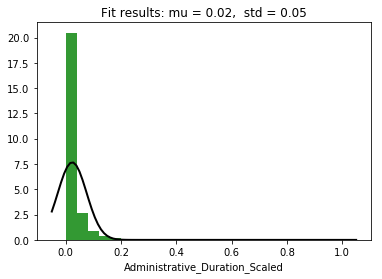

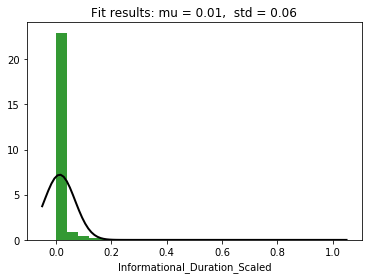

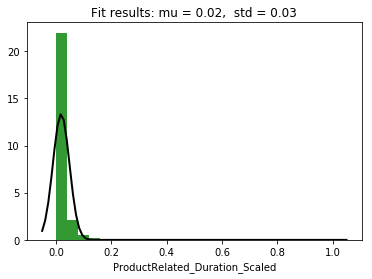

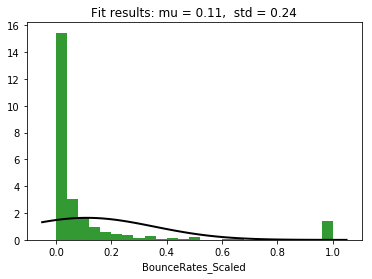

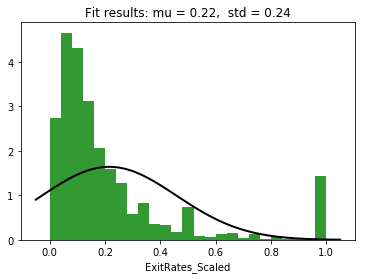

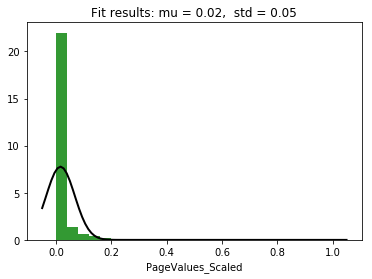

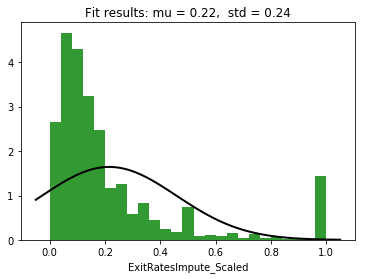

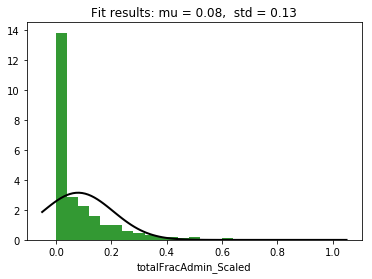

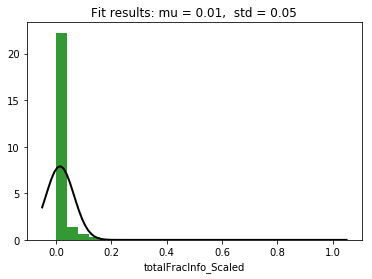

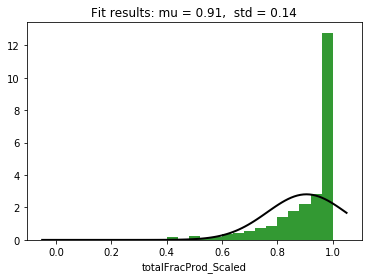

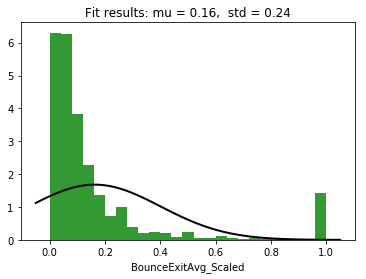

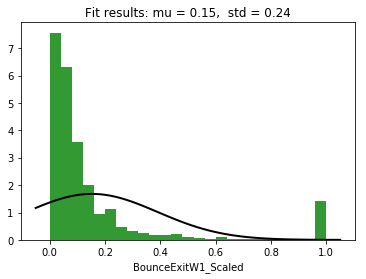

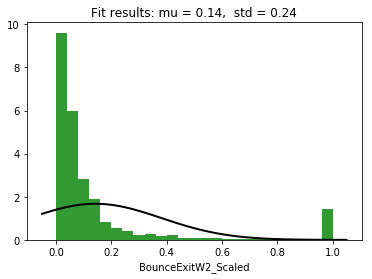

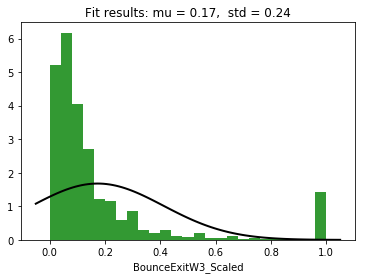

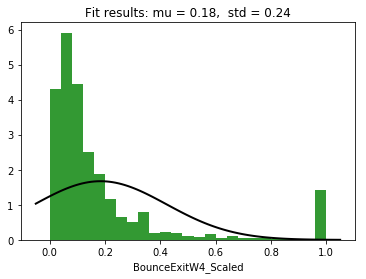

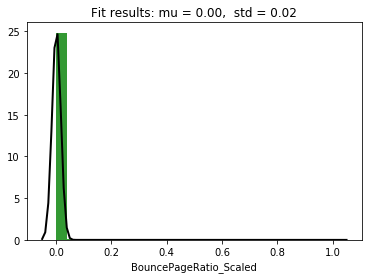

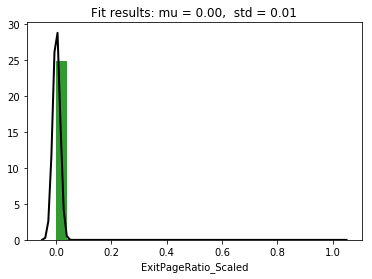

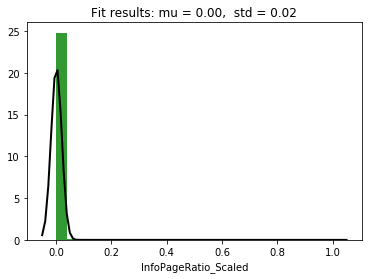

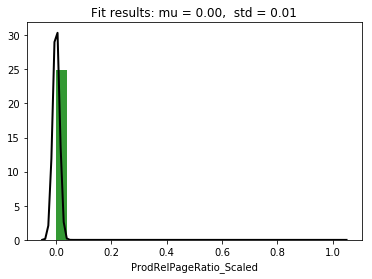

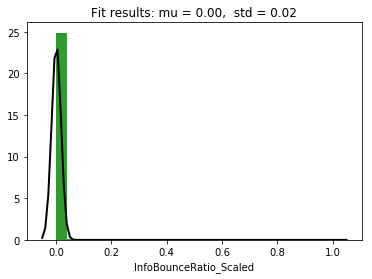

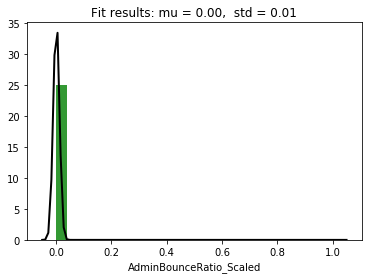

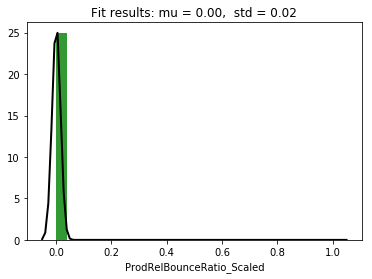

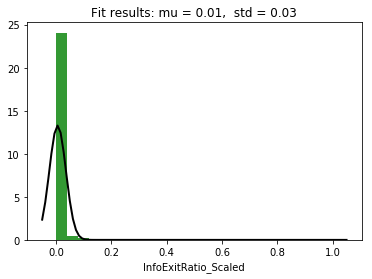

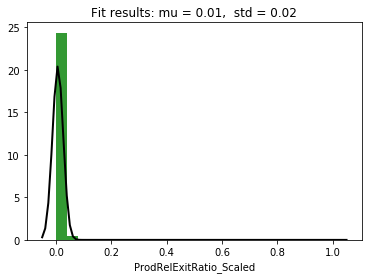

In [14]:
for col in normalization_df_cols:
    plot_hist(normalization_df, col)

### Applying Normalization

In [15]:
# innitial yeo-johnson normalization
for col in normalization_needed:
    if normalization_df[col].skew() > 0.5:
        normalization_df[col] = stats.yeojohnson(normalization_df[col])[0]
    
# replace -0 with 0 
normalization_df = normalization_df.replace(-0, 0)

# square-root transformation for positively/rightly skewed features that still have a skew > 0.5 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        normalization_df[col] = np.sqrt(normalization_df[col])
        
# left skew transformation
normalization_df['totalFracProd_Scaled'] = normalization_df['totalFracProd_Scaled']**2

# right manual transformation
normalization_df['AdminBounceRatio_Scaled'] = np.sqrt(normalization_df['AdminBounceRatio_Scaled'])
normalization_df['ProdRelBounceRatio_Scaled'] = np.sqrt(np.sqrt(normalization_df['ProdRelBounceRatio_Scaled']))

### Skew after normalization

In [16]:
not_normalized = []
# if still not normal display 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    else:
         print('Normalized', col,normalization_df[col].skew())

Normalized Administrative_Duration_Scaled 0.3295801795635637
Right skew:  Informational_Duration_Scaled 1.7326012884342452
Normalized ProductRelated_Duration_Scaled -0.23543933031636485
Normalized BounceRates_Scaled 0.3262257513950875
Normalized ExitRates_Scaled 0.3379450817642422
Right skew:  PageValues_Scaled 1.4692374319742973
Normalized ExitRatesImpute_Scaled 0.34543199073436326
Normalized totalFracAdmin_Scaled 0.15463883173278434
Right skew:  totalFracInfo_Scaled 1.4670525404458559
Left skew:  totalFracProd_Scaled -1.5358710010478271
Normalized BounceExitAvg_Scaled -0.14021732571738893
Normalized BounceExitW1_Scaled -0.06154026184381935
Normalized BounceExitW2_Scaled 0.036799663481299594
Normalized BounceExitW3_Scaled 0.4776758903657082
Normalized BounceExitW4_Scaled 0.43335849977275076
Right skew:  BouncePageRatio_Scaled 2.4608667487409366
Right skew:  ExitPageRatio_Scaled 1.6922979051299853
Right skew:  InfoPageRatio_Scaled 3.3982797233166844
Right skew:  ProdRelPageRatio_Scaled

In [17]:
print('Number of features that were not normalized: ',len(not_normalized))
print('Number of features that were normalized: ', len(normalization_needed) - len(not_normalized))

Number of features that were not normalized:  10
Number of features that were normalized:  14


In [18]:
normalization_df.to_csv('PipelineA-Normalize_Skew.csv')